<a href="https://colab.research.google.com/github/Yashashwee/cogni_internship/blob/main/HyperparameterSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explores the different search methods used for hyperparameter tuning

In [16]:
import numpy as np

In [3]:
#First we read the dataset
import pandas as pd


url = 'https://github.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/blob/e1fa53cbce8eeaa175f11b94f2e2543ad7d75600/LifeUniverseAndEverything.xlsx'

df = pd.read_excel('/content/LifeUniverseAndEverything.xlsx')

df.head() 

,Life,O2,O3,H2O,N2,H2,Sunlight,Aliens,Plants
0,5,6,38,48,25,38,0,1,1
1,4,0,4,2,6,13,0,1,0
2,4,11,3,78,30,15,0,0,1
3,0,22,30,68,28,23,0,1,0
4,10,20,23,56,20,27,1,0,1


In [25]:
#let us now do some basic preprocessing 
from sklearn.preprocessing import StandardScaler,OneHotEncoder

scaled = df[['O2','O3','H2O','N2','H2']]
onehot = df[['Sunlight','Aliens','Plants']]

scaler=StandardScaler()
scaler.fit(scaled)
scaled = scaler.transform(scaled)

enc = OneHotEncoder()
enc.fit(onehot)
onehot=enc.transform(onehot).toarray()

X = np.concatenate((scaled,onehot),axis=1)
y=df['Life']

In [13]:
!pip3 install scikit-optimize

     |████████████████████████████████| 100 kB 3.8 MB/s 


In [30]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from scipy.stats import loguniform, randint

lgb = LGBMClassifier()


In [28]:
#for grid search


param_grid = {
    "classifier__learning_rate": [0.0001, 0.0005, 0.001, 0.01, 0.1],
    "classifier__n_estimators": [100, 300, 600, 800, 1000],
    "classifier__max_depth": [ 4, 20, 100, 250, 400] 
}

reg_grid = GridSearchCV(lgb,
                        param_grid=param_grid
                       )

model_grid = reg_grid.fit(X, y)


In [32]:
#let us now try random search

n_iter = 70

param_grid = {
    "classifier__learning_rate": loguniform(1e-4, 0.1),
    "classifier__n_estimators": randint(100,1000),
    "classifier__max_depth": randint(4, 400) 
}

reg_rand = RandomizedSearchCV(lgb,
                         param_distributions=param_grid,
                         n_iter=n_iter,
                         cv=5,
                         n_jobs=8,
                         random_state=42)

model_rand = reg_rand.fit(X, y)

In [33]:
# Now let us try bayesian search
n_iter = 70

param_grid = {
    "classifier__learning_rate": (0.0001, 0.1, "log-uniform"),
    "classifier__n_estimators": (100,  1000) ,
    "classifier__max_depth": (4, 400) 
}

reg_bay = BayesSearchCV(estimator=lgb,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    random_state=123)

model_bay = reg_bay.fit(X, y)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


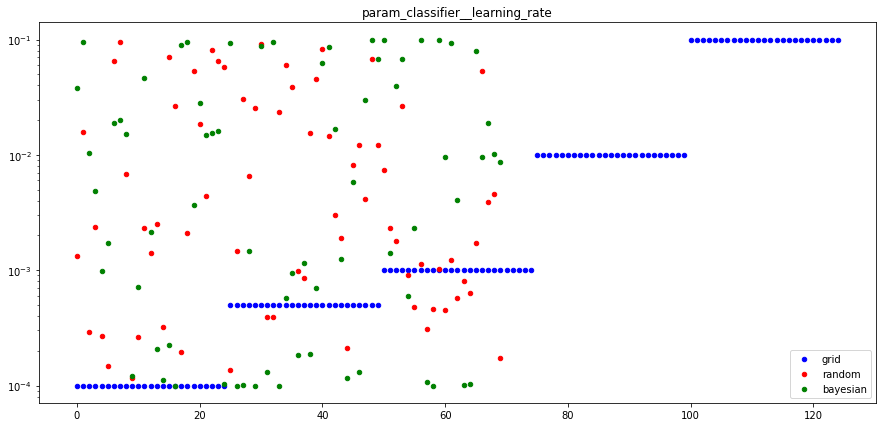

In [34]:
#finally we visualize our results
import matplotlib.pyplot as plt

%matplotlib inline

param = 'param_classifier__learning_rate'

grid = model_grid.cv_results_[param]
rand = model_rand.cv_results_[param]
bay = model_bay.cv_results_[param]

fig = plt.figure(figsize=(15, 7))

ax = plt.gca()
ax.scatter(np.arange(len(grid)), grid.data, c='b', s=20, label='grid');
ax.scatter(np.arange(len(rand)), rand.data, c='r', s=20, label='random');
ax.scatter(np.arange(len(bay)), bay, c='g', s=20, label='bayesian');
ax.set_yscale('log')

plt.legend();
plt.title(param);